# Learning task 1 - RobotArm

# Overall analysis 

In [30]:
import pandas as pd 
from distances import *
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

from scipy.stats import mannwhitneyu, ttest_ind
from scipy import stats

In [31]:
df = pd.read_csv("data/ldw_2023_pilot_coding_tasks_outputs_processed_3.csv")

folder = "plot_test"

robotarm_df = df[df['Activity Name'] == 'RobotArm']
robotarm = robotarm_df[robotarm_df['Activity ID'] == "P1M120"]

key_vector_l1 = "['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,ra-world-shape ra-world-shapeA,', 'E,E,E,E,ra-world-shape ra-world-shapeA,false']"
initial_worldspace = "['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'ra-world-shape ra-world-shapeA,E,E,E,E,', 'ra-world-shape ra-world-shapeA,E,E,E,E,false']" 

In [32]:
initial_length = robotarm.shape[0]
length = robotarm.shape[0]
print(f"Number of rows before filtering: {initial_length}")

Number of rows before filtering: 1967


### Cleaning the data

Sanity check to verify if the failing students do not overlap over the successful students (or vice-versa)

In [33]:
robotarm_grouped = robotarm.groupby('Student ID').apply(lambda x: 1 in x['WorldspaceScore'].values)

# separate the students into two groups
success_students = robotarm_grouped[robotarm_grouped == True].index
failure_students = robotarm_grouped[robotarm_grouped == False].index

set(success_students.intersection(failure_students)) == set()

# we can safely continue without separating the datasets

True

### Index the tentatives

In [34]:
robotarm = robotarm.groupby('Student ID', as_index=False).apply(lambda x: x.sort_values(by='timestamp')).reset_index(drop=True)
robotarm['index'] = robotarm.groupby('Student ID').cumcount()

### Add initial vector and distance for each student

In [35]:
data = robotarm[["Student ID", "WorldSpace", "index"]]

# dictionnary to reassign index to the correct order, where index 0 becomes 1 and index 1 becomes 2
index_dict = {i: i+1 for i in range(len(data['index'].unique()))}

data['index'] = data['index'].apply(lambda x: index_dict[x])

initial_data = pd.DataFrame({'Student ID': data['Student ID'].unique(), 'WorldSpace': initial_worldspace, 'index': 0,})
data = pd.concat([data, initial_data])

data = data.groupby('Student ID', as_index=False).apply(lambda x: x.sort_values(by='index')).reset_index(drop=True)

/var/folders/59/4wtmm5814rs2dj58pby6qq240000gn/T/ipykernel_11071/2266424703.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['index'] = data['index'].apply(lambda x: index_dict[x])


### Create column corresponding to percentage of activity completed

In [36]:
data['pct_activity'] = data['index'] / data.groupby('Student ID')['index'].transform('max')

In [37]:
nb_student = len(robotarm['Student ID'].unique())
print(f"Number of students: {nb_student}")

Number of students: 386


In [38]:
# create column max tentative which correspond to the last row column "index" for each student
data["nb_tentative"] = data.groupby('Student ID')['index'].transform('max')

### Separate the successful and failing students

In [39]:
data_success = data[data['Student ID'].isin(success_students)]
data_fail = data[data['Student ID'].isin(failure_students)]

print("Total number of students: ", len(data['Student ID'].unique()))
print("Number of students who succeeded: ", len(data_success['Student ID'].unique()))
print("Number of students who failed: ", len(data_fail['Student ID'].unique()))

Total number of students:  386
Number of students who succeeded:  273
Number of students who failed:  113


In [40]:
data_success['success'] = 1
data_fail['success'] = 0

data = pd.concat([data_success, data_fail])

/var/folders/59/4wtmm5814rs2dj58pby6qq240000gn/T/ipykernel_11071/1419184903.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_success['success'] = 1
/var/folders/59/4wtmm5814rs2dj58pby6qq240000gn/T/ipykernel_11071/1419184903.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fail['success'] = 0


In [41]:
# group by Student ID and compute the mean euclidean distance 
data_grouped_per_student = data.groupby('Student ID').agg({'nb_tentative': 'max'})
data_grouped_per_student.columns = ['nb_tentative']

data_grouped_per_student_success = data_grouped_per_student[data_grouped_per_student.index.isin(success_students)]
data_grouped_per_student_fail = data_grouped_per_student[data_grouped_per_student.index.isin(failure_students)]

data_grouped_per_student_success['success'] = 1
data_grouped_per_student_fail['success'] = 0

data_grouped_per_student = pd.concat([data_grouped_per_student_success, data_grouped_per_student_fail])

/var/folders/59/4wtmm5814rs2dj58pby6qq240000gn/T/ipykernel_11071/2436364172.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_grouped_per_student_success['success'] = 1
/var/folders/59/4wtmm5814rs2dj58pby6qq240000gn/T/ipykernel_11071/2436364172.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_grouped_per_student_fail['success'] = 0


# Analysis 

In [42]:
data[['index', 'nb_tentative', 'pct_activity']].describe()

,index,nb_tentative,pct_activity
count,2353.000000,2353.000000,2353.000000
mean,3.841054,7.682108,0.500000
std,3.890320,5.176979,0.347047
min,0.000000,1.000000,0.000000
25%,1.000000,4.000000,0.200000
50%,3.000000,6.000000,0.500000
75%,5.000000,10.000000,0.800000
max,26.000000,26.000000,1.000000


In [43]:
data_success[['index', 'nb_tentative', 'pct_activity']].describe()

,index,nb_tentative,pct_activity
count,1618.000000,1618.000000,1618.000000
mean,3.457973,6.915946,0.500000
std,3.388989,4.362414,0.347496
min,0.000000,1.000000,0.000000
25%,1.000000,4.000000,0.200000
50%,3.000000,6.000000,0.500000
75%,5.000000,9.000000,0.800000
max,22.000000,22.000000,1.000000


In [44]:
data_grouped_per_student_success.describe()

,nb_tentative,success
count,273.000000,273.0
mean,4.926740,1.0
std,3.439891,0.0
min,1.000000,1.0
25%,3.000000,1.0
50%,4.000000,1.0
75%,6.000000,1.0
max,22.000000,1.0


In [45]:
data_fail[['index', 'nb_tentative', 'pct_activity']].describe()

,index,nb_tentative,pct_activity
count,735.000000,735.000000,735.000000
mean,4.684354,9.368707,0.500000
std,4.707344,6.309791,0.346292
min,0.000000,1.000000,0.000000
25%,1.000000,4.000000,0.200000
50%,3.000000,9.000000,0.500000
75%,7.000000,13.000000,0.800000
max,26.000000,26.000000,1.000000


In [46]:
data_grouped_per_student_fail.describe()

,nb_tentative,success
count,113.000000,113.0
mean,5.504425,0.0
std,5.035807,0.0
min,1.000000,0.0
25%,1.000000,0.0
50%,4.000000,0.0
75%,8.000000,0.0
max,26.000000,0.0


In [47]:
data_grouped_per_student.describe()

,nb_tentative,success
count,386.000000,386.000000
mean,5.095855,0.707254
std,3.975723,0.455613
min,1.000000,0.000000
25%,2.000000,0.000000
50%,4.000000,1.000000
75%,7.000000,1.000000
max,26.000000,1.000000


### Number of tentatives/runs

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: Futur

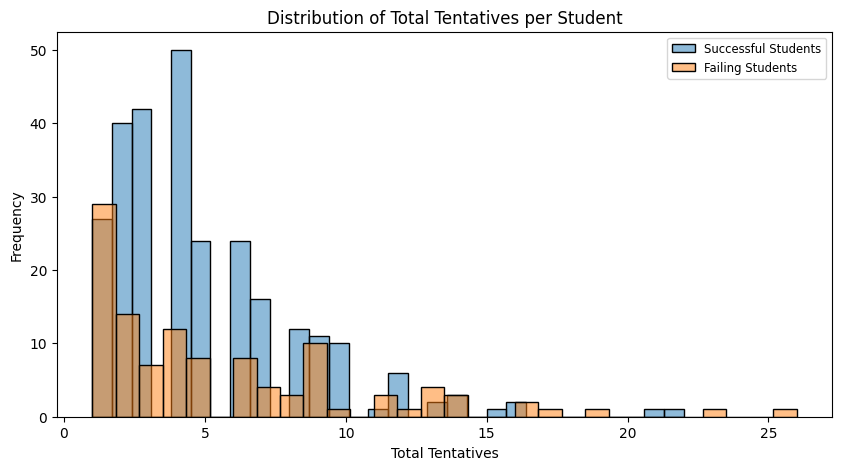

In [48]:
# Create histograms for the number of tentatives
plt.figure(figsize=(10, 5))
sns.histplot(data_grouped_per_student_success['nb_tentative'], bins=30, label='Successful Students', alpha=0.5)
sns.histplot(data_grouped_per_student_fail['nb_tentative'], bins=30, label='Failing Students', alpha=0.5)
plt.xlabel('Total Tentatives')
plt.ylabel('Frequency')
plt.title('Distribution of Total Tentatives per Student')
plt.legend(fontsize='small')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


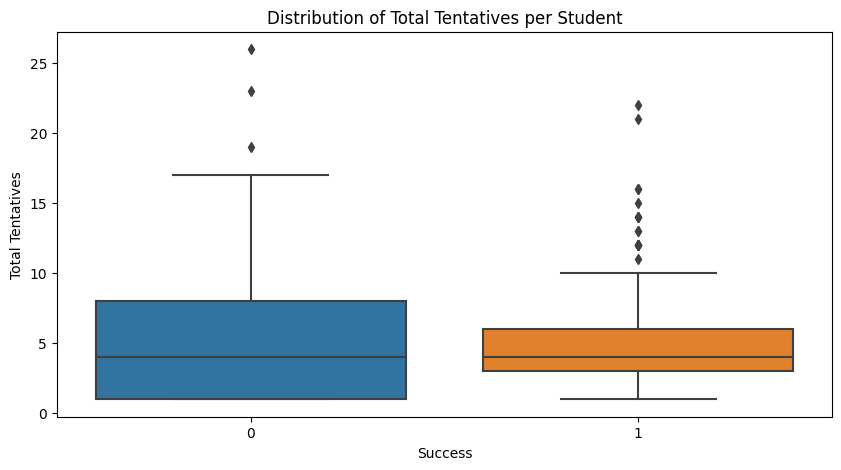

In [49]:
# Create box plots for the number of tentatives
plt.figure(figsize=(10, 5))
sns.boxplot(x='success', y='nb_tentative', data=data_grouped_per_student)

plt.xlabel('Success')
plt.ylabel('Total Tentatives')
plt.title('Distribution of Total Tentatives per Student')

plt.savefig(f"{folder}/boxplot_nb_tentatives_per_student_l1.png")
plt.show()

In [50]:
# Assuming 'tentatives_successful' and 'tentatives_failing' are arrays of number of tentatives
statistic, p_value = mannwhitneyu(data_grouped_per_student_success['nb_tentative'], data_grouped_per_student_fail['nb_tentative'])

# Interpret the results
if p_value < 0.05:
    print("There is a significant difference between successful and failing students in terms of number of tentatives (p < 0.05)")
else:
    print("There is no significant difference between successful and failing students in terms of number of tentatives (p >= 0.05)")


There is no significant difference between successful and failing students in terms of number of tentatives (p >= 0.05)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

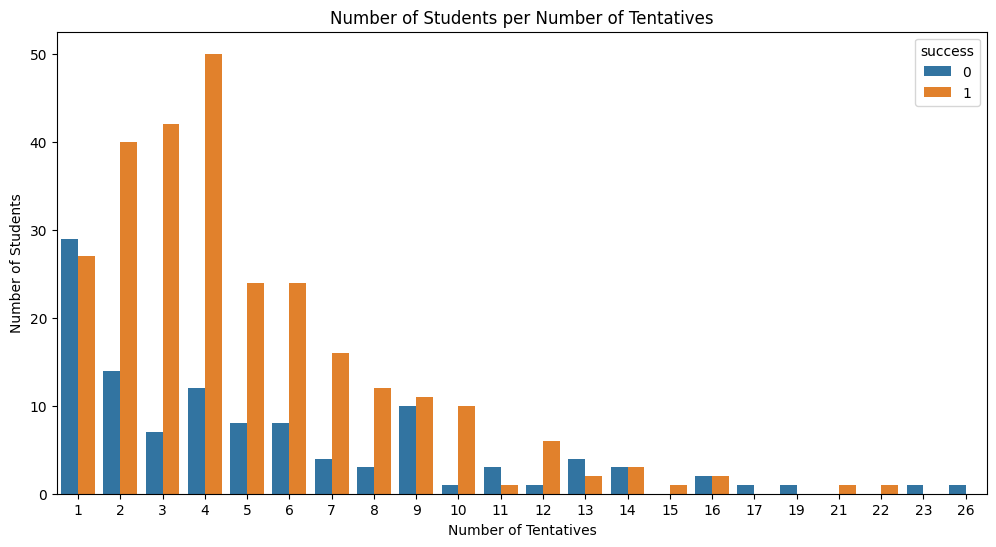

In [51]:
# bar plot of the number of students per number of tentatives
fig, ax = plt.subplots(figsize=(12, 6))

sns.countplot(x='nb_tentative', hue='success', data=data_grouped_per_student, ax=ax)

# add title and labels
ax.set_title('Number of Students per Number of Tentatives')
ax.set_xlabel('Number of Tentatives')
ax.set_ylabel('Number of Students')

plt.savefig(f'{folder}/students_per_tentatives_l1.png')
plt.show()

# Learning Task 2

In [52]:
# CHANGE HERE IF NEEDED

df = pd.read_csv("data/ldw_2023_pilot_coding_tasks_outputs_processed_3.csv")

robotarm_df = df[df['Activity Name'] == 'RobotArm']
robotarm = robotarm_df[robotarm_df['Activity ID'] == "P1M123"]

key_vector_l1 = "['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,ra-world-shape ra-world-shapeB,E,ra-world-shape ra-world-shapeA,E,', 'E,ra-world-shape ra-world-shapeB,E,ra-world-shape ra-world-shapeA,E,false']"
initial_worldspace = "['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,ra-world-shape ra-world-shapeB,E,E,', 'E,E,ra-world-shape ra-world-shapeA,E,E,', 'E,E,ra-world-shape ra-world-shapeA,E,E,', 'E,E,ra-world-shape ra-world-shapeB,E,E,false']"

In [53]:
initial_length = robotarm.shape[0]
length = robotarm.shape[0]
print(f"Number of rows before filtering: {initial_length}")

Number of rows before filtering: 2152


In [54]:
robotarm_grouped = robotarm.groupby('Student ID').apply(lambda x: 1 in x['WorldspaceScore'].values)

# separate the students into two groups
success_students = robotarm_grouped[robotarm_grouped == True].index
failure_students = robotarm_grouped[robotarm_grouped == False].index

set(success_students.intersection(failure_students)) == set()

# we can safely continue without separating the datasets

True

### Index the tentatives

In [55]:
robotarm = robotarm.groupby('Student ID', as_index=False).apply(lambda x: x.sort_values(by='timestamp')).reset_index(drop=True)
robotarm['index'] = robotarm.groupby('Student ID').cumcount()

### Add initial vector and distance for each student

In [56]:
data = robotarm[["Student ID", "WorldSpace", "index"]]

# dictionnary to reassign index to the correct order, where index 0 becomes 1 and index 1 becomes 2
index_dict = {i: i+1 for i in range(len(data['index'].unique()))}

data['index'] = data['index'].apply(lambda x: index_dict[x])

initial_data = pd.DataFrame({'Student ID': data['Student ID'].unique(), 'WorldSpace': initial_worldspace, 'index': 0,})
data = pd.concat([data, initial_data])

data = data.groupby('Student ID', as_index=False).apply(lambda x: x.sort_values(by='index')).reset_index(drop=True)

/var/folders/59/4wtmm5814rs2dj58pby6qq240000gn/T/ipykernel_11071/2266424703.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['index'] = data['index'].apply(lambda x: index_dict[x])


### Create column corresponding to percentage of activity completed

In [57]:
data['pct_activity'] = data['index'] / data.groupby('Student ID')['index'].transform('max')

In [58]:
nb_student = len(robotarm['Student ID'].unique())
print(f"Number of students: {nb_student}")

Number of students: 326


In [59]:
# create column max tentative which correspond to the last row column "index" for each student
data["nb_tentative"] = data.groupby('Student ID')['index'].transform('max')

### Separate the successful and failing students

In [60]:
data_success = data[data['Student ID'].isin(success_students)]
data_fail = data[data['Student ID'].isin(failure_students)]

print("Total number of students: ", len(data['Student ID'].unique()))
print("Number of students who succeeded: ", len(data_success['Student ID'].unique()))
print("Number of students who failed: ", len(data_fail['Student ID'].unique()))

Total number of students:  326
Number of students who succeeded:  212
Number of students who failed:  114


In [61]:
data_success['success'] = 1
data_fail['success'] = 0

data = pd.concat([data_success, data_fail])

/var/folders/59/4wtmm5814rs2dj58pby6qq240000gn/T/ipykernel_11071/1419184903.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_success['success'] = 1
/var/folders/59/4wtmm5814rs2dj58pby6qq240000gn/T/ipykernel_11071/1419184903.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fail['success'] = 0


In [62]:
# group by Student ID and compute the mean euclidean distance 
data_grouped_per_student = data.groupby('Student ID').agg({'nb_tentative': 'max'})
data_grouped_per_student.columns = ['nb_tentative']

data_grouped_per_student_success = data_grouped_per_student[data_grouped_per_student.index.isin(success_students)]
data_grouped_per_student_fail = data_grouped_per_student[data_grouped_per_student.index.isin(failure_students)]

data_grouped_per_student_success['success'] = 1
data_grouped_per_student_fail['success'] = 0

data_grouped_per_student = pd.concat([data_grouped_per_student_success, data_grouped_per_student_fail])

/var/folders/59/4wtmm5814rs2dj58pby6qq240000gn/T/ipykernel_11071/2436364172.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_grouped_per_student_success['success'] = 1
/var/folders/59/4wtmm5814rs2dj58pby6qq240000gn/T/ipykernel_11071/2436364172.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_grouped_per_student_fail['success'] = 0


# Analysis 

In [63]:
data[['index', 'nb_tentative', 'pct_activity']].describe()

,index,nb_tentative,pct_activity
count,2478.000000,2478.000000,2478.000000
mean,6.069411,12.138822,0.500000
std,7.859692,11.933138,0.335316
min,0.000000,1.000000,0.000000
25%,1.000000,5.000000,0.200000
50%,4.000000,9.000000,0.500000
75%,8.000000,14.000000,0.800000
max,64.000000,64.000000,1.000000


In [64]:
data_success[['index', 'nb_tentative', 'pct_activity']].describe()

,index,nb_tentative,pct_activity
count,1486.000000,1486.000000,1486.000000
mean,4.483849,8.967699,0.500000
std,4.364774,5.705125,0.338826
min,0.000000,1.000000,0.000000
25%,1.000000,5.000000,0.200000
50%,3.000000,8.000000,0.500000
75%,6.000000,12.000000,0.800000
max,31.000000,31.000000,1.000000


In [65]:
data_grouped_per_student_success.describe()

,nb_tentative,success
count,212.000000,212.0
mean,6.009434,1.0
std,4.564431,0.0
min,1.000000,1.0
25%,2.000000,1.0
50%,5.000000,1.0
75%,8.000000,1.0
max,31.000000,1.0


In [66]:
data_fail[['index', 'nb_tentative', 'pct_activity']].describe()

,index,nb_tentative,pct_activity
count,992.000000,992.000000,992.000000
mean,8.444556,16.889113,0.500000
std,10.790779,16.416065,0.330157
min,0.000000,1.000000,0.000000
25%,2.000000,6.000000,0.202344
50%,5.000000,11.000000,0.500000
75%,11.000000,22.000000,0.797656
max,64.000000,64.000000,1.000000


In [67]:
data_grouped_per_student_fail.describe()

,nb_tentative,success
count,114.000000,114.0
mean,7.701754,0.0
std,8.980736,0.0
min,1.000000,0.0
25%,2.000000,0.0
50%,5.000000,0.0
75%,9.750000,0.0
max,64.000000,0.0


In [68]:
data_grouped_per_student.describe()

,nb_tentative,success
count,326.000000,326.000000
mean,6.601227,0.650307
std,6.497848,0.477606
min,1.000000,0.000000
25%,2.000000,0.000000
50%,5.000000,1.000000
75%,9.000000,1.000000
max,64.000000,1.000000


### Number of tentatives/runs

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


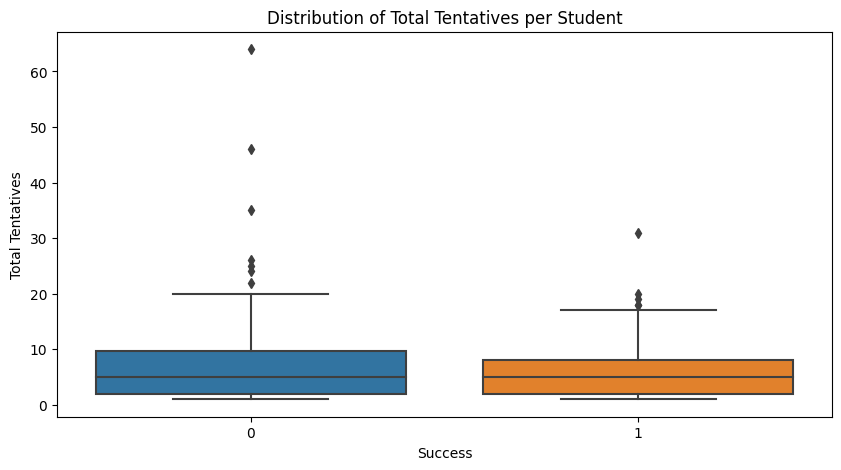

In [69]:
# Create box plots for the number of tentatives
plt.figure(figsize=(10, 5))
sns.boxplot(x='success', y='nb_tentative', data=data_grouped_per_student)

plt.xlabel('Success')
plt.ylabel('Total Tentatives')
plt.title('Distribution of Total Tentatives per Student')

plt.savefig(f"{folder}/boxplot_nb_tentatives_per_student_l2.png")
plt.show()

In [70]:
# Assuming 'tentatives_successful' and 'tentatives_failing' are arrays of number of tentatives
statistic, p_value = mannwhitneyu(data_grouped_per_student_success['nb_tentative'], data_grouped_per_student_fail['nb_tentative'])

# Interpret the results
if p_value < 0.05:
    print("There is a significant difference between successful and failing students in terms of number of tentatives (p < 0.05)")
else:
    print("There is no significant difference between successful and failing students in terms of number of tentatives (p >= 0.05)")


There is no significant difference between successful and failing students in terms of number of tentatives (p >= 0.05)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

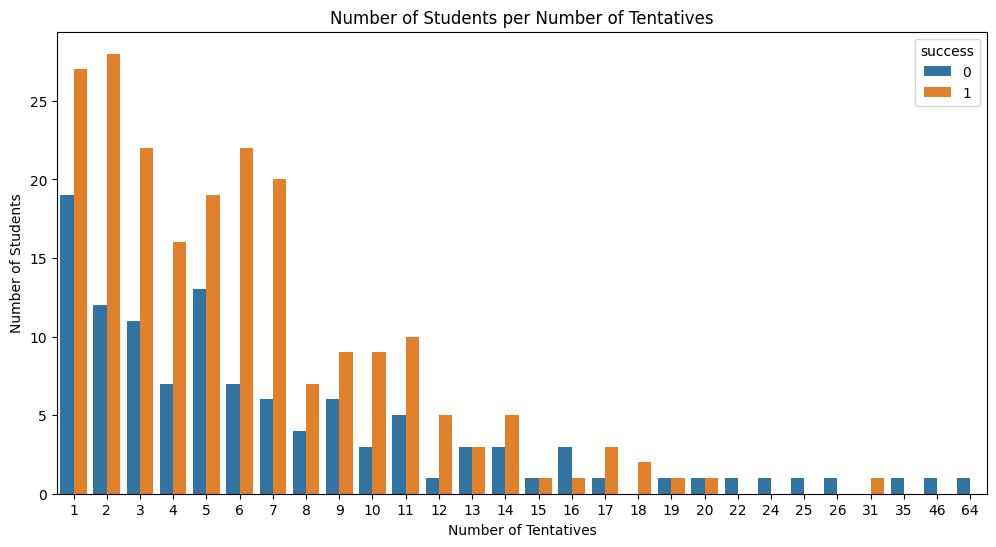

In [71]:
# bar plot of the number of students per number of tentatives
fig, ax = plt.subplots(figsize=(12, 6))

sns.countplot(x='nb_tentative', hue='success', data=data_grouped_per_student, ax=ax)

# add title and labels
ax.set_title('Number of Students per Number of Tentatives')
ax.set_xlabel('Number of Tentatives')
ax.set_ylabel('Number of Students')

plt.savefig(f'{folder}/students_per_tentatives_l2.png')
plt.show()

# Learning task 3

In [123]:
df = pd.read_csv("data/ldw_2023_pilot_coding_tasks_outputs_processed_3.csv")

#robotarm_df = df[df['Activity Name'] == 'RobotArm']
robotarm = df[df['Activity ID'] == "P1M124"]

key_vector_l3 = "['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'ra-world-shape ra-world-shapeA,E,E,E,E,', 'ra-world-shape ra-world-shapeA,ra-world-shape ra-world-shapeB,E,E,E,', 'ra-world-shape ra-world-shapeA,ra-world-shape ra-world-shapeB,E,E,E,false']"
initial_worldspace = "['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,ra-world-shape ra-world-shapeB,E,E,', 'E,ra-world-shape ra-world-shapeA,ra-world-shape ra-world-shapeA,E,E,', 'E,ra-world-shape ra-world-shapeA,ra-world-shape ra-world-shapeB,E,E,false']" 

In [124]:
initial_length = robotarm.shape[0]
length = robotarm.shape[0]
print(f"Number of rows before filtering: {initial_length}")

Number of rows before filtering: 1188


In [125]:
robotarm_grouped = robotarm.groupby('Student ID').apply(lambda x: 1 in x['WorldspaceScore'].values)

# separate the students into two groups
success_students = robotarm_grouped[robotarm_grouped == True].index
failure_students = robotarm_grouped[robotarm_grouped == False].index

set(success_students.intersection(failure_students)) == set()

# we can safely continue without separating the datasets

True

### Index the tentatives

In [126]:
robotarm = robotarm.groupby('Student ID', as_index=False).apply(lambda x: x.sort_values(by='timestamp')).reset_index(drop=True)
robotarm['index'] = robotarm.groupby('Student ID').cumcount()

### Add initial vector and distance for each student

In [127]:
data = robotarm[["Student ID", "WorldSpace", "index"]]

# dictionnary to reassign index to the correct order, where index 0 becomes 1 and index 1 becomes 2
index_dict = {i: i+1 for i in range(len(data['index'].unique()))}

data['index'] = data['index'].apply(lambda x: index_dict[x])

initial_data = pd.DataFrame({'Student ID': data['Student ID'].unique(), 'WorldSpace': initial_worldspace, 'index': 0,})
data = pd.concat([data, initial_data])

data = data.groupby('Student ID', as_index=False).apply(lambda x: x.sort_values(by='index')).reset_index(drop=True)

/var/folders/59/4wtmm5814rs2dj58pby6qq240000gn/T/ipykernel_11071/2266424703.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['index'] = data['index'].apply(lambda x: index_dict[x])


### Create column corresponding to percentage of activity completed

In [128]:
data['pct_activity'] = data['index'] / data.groupby('Student ID')['index'].transform('max')

In [129]:
nb_student = len(robotarm['Student ID'].unique())
print(f"Number of students: {nb_student}")

Number of students: 245


In [130]:
nb_student = len(data['Student ID'].unique())
print(f"Number of students: {nb_student}")

Number of students: 245


In [122]:
# create column max tentative which correspond to the last row column "index" for each student
data["nb_tentative"] = data.groupby('Student ID')['index'].transform('max')

### Separate the successful and failing students

In [86]:
data_success = data[data['Student ID'].isin(success_students)]
data_fail = data[data['Student ID'].isin(failure_students)]

print("Total number of students: ", len(data['Student ID'].unique()))
print("Number of students who succeeded: ", len(data_success['Student ID'].unique()))
print("Number of students who failed: ", len(data_fail['Student ID'].unique()))

Total number of students:  245
Number of students who succeeded:  110
Number of students who failed:  135


In [87]:
data_success['success'] = 1
data_fail['success'] = 0

data = pd.concat([data_success, data_fail])

/var/folders/59/4wtmm5814rs2dj58pby6qq240000gn/T/ipykernel_11071/1419184903.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_success['success'] = 1
/var/folders/59/4wtmm5814rs2dj58pby6qq240000gn/T/ipykernel_11071/1419184903.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fail['success'] = 0


In [88]:
# group by Student ID and compute the mean euclidean distance 
data_grouped_per_student = data.groupby('Student ID').agg({'nb_tentative': 'max'})
data_grouped_per_student.columns = ['nb_tentative']

data_grouped_per_student_success = data_grouped_per_student[data_grouped_per_student.index.isin(success_students)]
data_grouped_per_student_fail = data_grouped_per_student[data_grouped_per_student.index.isin(failure_students)]

data_grouped_per_student_success['success'] = 1
data_grouped_per_student_fail['success'] = 0

data_grouped_per_student = pd.concat([data_grouped_per_student_success, data_grouped_per_student_fail])

/var/folders/59/4wtmm5814rs2dj58pby6qq240000gn/T/ipykernel_11071/2436364172.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_grouped_per_student_success['success'] = 1
/var/folders/59/4wtmm5814rs2dj58pby6qq240000gn/T/ipykernel_11071/2436364172.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_grouped_per_student_fail['success'] = 0


# Analysis 

In [89]:
data[['index', 'nb_tentative', 'pct_activity']].describe()

,index,nb_tentative,pct_activity
count,1433.000000,1433.000000,1433.000000
mean,3.851361,7.702722,0.500000
std,4.874066,7.250667,0.349013
min,0.000000,1.000000,0.000000
25%,1.000000,4.000000,0.200000
50%,3.000000,6.000000,0.500000
75%,5.000000,9.000000,0.800000
max,40.000000,40.000000,1.000000


In [90]:
data_success[['index', 'nb_tentative', 'pct_activity']].describe()

,index,nb_tentative,pct_activity
count,673.000000,673.000000,673.000000
mean,3.136701,6.273403,0.500000
std,2.716085,3.022656,0.342973
min,0.000000,1.000000,0.000000
25%,1.000000,4.000000,0.200000
50%,3.000000,5.000000,0.500000
75%,5.000000,8.000000,0.800000
max,14.000000,14.000000,1.000000


In [91]:
data_grouped_per_student_success.describe()

,nb_tentative,success
count,110.000000,110.0
mean,5.118182,1.0
std,2.670710,0.0
min,1.000000,1.0
25%,3.000000,1.0
50%,4.000000,1.0
75%,6.750000,1.0
max,14.000000,1.0


In [92]:
data_fail[['index', 'nb_tentative', 'pct_activity']].describe()

,index,nb_tentative,pct_activity
count,760.000000,760.000000,760.000000
mean,4.484211,8.968421,0.500000
std,6.118484,9.363909,0.354501
min,0.000000,1.000000,0.000000
25%,1.000000,3.750000,0.184343
50%,3.000000,6.000000,0.500000
75%,5.000000,11.000000,0.815657
max,40.000000,40.000000,1.000000


In [93]:
data_grouped_per_student_fail.describe()

,nb_tentative,success
count,135.000000,135.0
mean,4.629630,0.0
std,4.960652,0.0
min,1.000000,0.0
25%,2.000000,0.0
50%,4.000000,0.0
75%,6.000000,0.0
max,40.000000,0.0


In [94]:
data_grouped_per_student.describe()

,nb_tentative,success
count,245.000000,245.000000
mean,4.848980,0.448980
std,4.093884,0.498408
min,1.000000,0.000000
25%,3.000000,0.000000
50%,4.000000,0.000000
75%,6.000000,1.000000
max,40.000000,1.000000


### Number of tentatives/runs

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


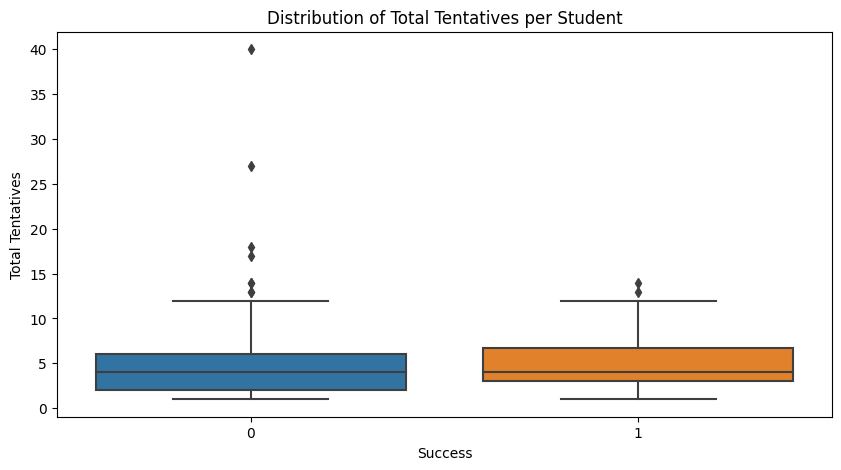

In [95]:
# Create box plots for the number of tentatives
plt.figure(figsize=(10, 5))
sns.boxplot(x='success', y='nb_tentative', data=data_grouped_per_student)

plt.xlabel('Success')
plt.ylabel('Total Tentatives')
plt.title('Distribution of Total Tentatives per Student')

plt.savefig(f"{folder}/boxplot_nb_tentatives_per_student_l3.png")
plt.show()

In [96]:
# Assuming 'tentatives_successful' and 'tentatives_failing' are arrays of number of tentatives
statistic, p_value = mannwhitneyu(data_grouped_per_student_success['nb_tentative'], data_grouped_per_student_fail['nb_tentative'])

# Interpret the results
if p_value < 0.05:
    print("There is a significant difference between successful and failing students in terms of number of tentatives (p < 0.05)")
else:
    print("There is no significant difference between successful and failing students in terms of number of tentatives (p >= 0.05)")


There is a significant difference between successful and failing students in terms of number of tentatives (p < 0.05)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

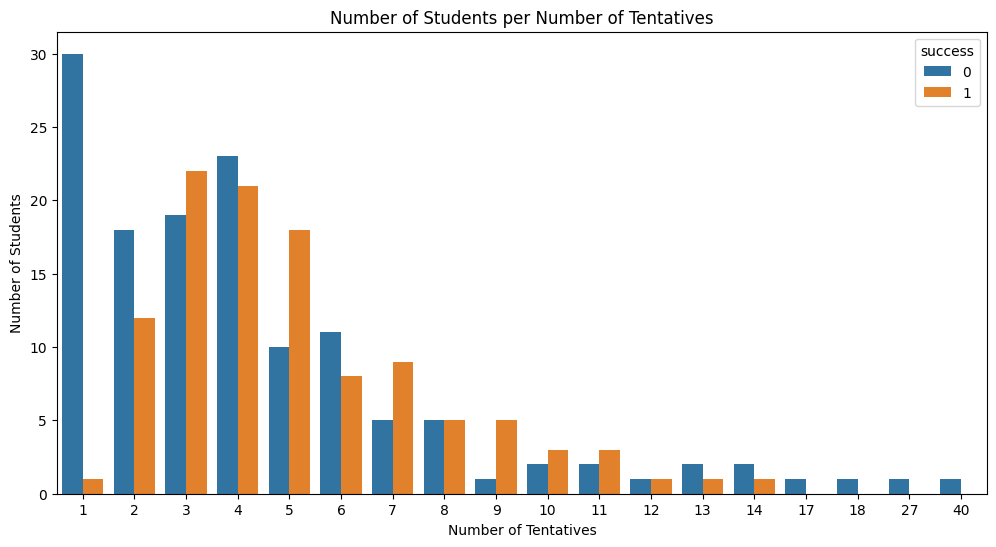

In [97]:
# bar plot of the number of students per number of tentatives
fig, ax = plt.subplots(figsize=(12, 6))

sns.countplot(x='nb_tentative', hue='success', data=data_grouped_per_student, ax=ax)

# add title and labels
ax.set_title('Number of Students per Number of Tentatives')
ax.set_xlabel('Number of Tentatives')
ax.set_ylabel('Number of Students')

plt.savefig(f'{folder}/students_per_tentatives_l3.png')
plt.show()

In [98]:
data

,Student ID,WorldSpace,index,pct_activity,nb_tentative,success
5,AUS123109,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",0,0.000000,3,1
6,AUS123109,"['E,E,ra-world-arm,E,E,', 'E,E,E,E,E,', 'E,E,E...",1,0.333333,3,1
7,AUS123109,"['ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E...",2,0.666667,3,1
8,AUS123109,"['E,ra-world-arm,E,E,E,', 'E,E,E,E,E,', 'E,E,E...",3,1.000000,3,1
12,AUS123505,"['E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,...",0,0.000000,11,1
...,...,...,...,...,...,...
1428,UK123022,"['E,E,ra-world-arm,E,E,', 'E,E,E,E,E,', 'E,E,E...",2,0.333333,6,0
1429,UK123022,NaN,3,0.500000,6,0
1430,UK123022,"['ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E...",4,0.666667,6,0
1431,UK123022,"['ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E...",5,0.833333,6,0


In [102]:
len(data['Student ID'].unique())

245

In [111]:
data_grouped_per_student

,nb_tentative,success
Student ID,,
AUS123109,3,1
AUS123505,11,1
AUS123613,4,1
AUS123757,2,1
AUS123837,5,1
...,...,...
NOR821209,1,0
UK123001,7,0
UK123007,4,0


In [112]:
data_grouped_per_student.groupby('nb_tentative').agg({'nb_tentative': 'count'})

,nb_tentative
nb_tentative,
1,31
2,30
3,41
4,44
5,28
6,19
7,14
8,10
9,6


In [100]:
data_success.groupby('nb_tentative').aggregate({'Student ID': 'count'})

,Student ID
nb_tentative,
1,2
2,36
3,88
4,105
5,108
6,56
7,72
8,45
9,50


In [101]:
data_fail.groupby('nb_tentative').aggregate({'Student ID': 'count'})

,Student ID
nb_tentative,
1,60
2,54
3,76
4,115
5,60
6,77
7,40
8,45
9,10
